### 加载数据集

上面的预处理基本没动，数据加载部分移动到了下一个单元格（方便二次拆分数据集）

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import shutil
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(42)

# 标准化
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# 加载完整数据集
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform)


# 随机抽取数据
def get_subset(dataset, ratio=1):
    indices = np.random.choice(
        len(dataset), size=int(len(dataset) * ratio), replace=False
    )
    return Subset(dataset, indices)

print("原始训练集大小：", len(train_dataset))
train_subset = get_subset(train_dataset)
test_subset = get_subset(test_dataset)
imgSize = train_subset[0][0].shape[1]
print("图像尺寸" + str(imgSize) + "x" + str(imgSize))

 21%|██        | 2.06M/9.91M [00:14<00:54, 143kB/s] 


KeyboardInterrupt: 

### 数据集二次划分

参考FNN处的划分幅度 ----> 训练：验证：测试=4.8:1.2:1

之前FNN的sklearn适合划分 `NumPy` 数组和 `Pandas DataFrame`，这里`Dataset`对象就直接用`pytorch`自带的了


In [5]:
# 划分验证集
check_size = int(0.2 * len(train_subset))
train_size = len(train_subset) - check_size
train_subset, check_subset = torch.utils.data.random_split(
    train_subset, [train_size, check_size]
)

DL_batch_size = 256
train_loader = DataLoader(train_subset, batch_size=DL_batch_size, shuffle=True, num_workers=2, pin_memory=True)
check_loader = DataLoader(check_subset, batch_size=DL_batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_subset, batch_size=DL_batch_size)

print(
    f"训练样本数: {len(train_subset)}, 验证样本数: {len(check_subset)}, 测试样本数: {len(test_subset)}"
)

训练样本数: 48000, 验证样本数: 12000, 测试样本数: 10000


### 部分图像及标签展示

我同时在做`CIFAR-10`的`CNN`实验，就顺便把那边的图像展示环节搬过来了

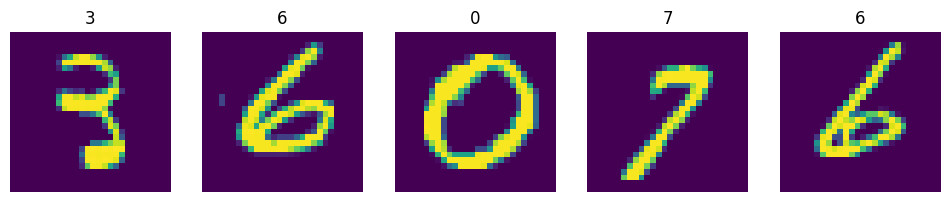

In [7]:
classes = (
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
)

show_size = 5   # 随机展示5张
_, random_subset = torch.utils.data.random_split(
    train_subset, [len(train_subset) - show_size, show_size]
)

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, (img, label) in enumerate(random_subset):
    img = img.numpy().transpose((1, 2, 0))  # 转换通道顺序为 HWC
    img = img * 0.5 + 0.5  # 反归一化到 [0,1]
    axes[i].imshow(img)
    axes[i].set_title(classes[label])
    axes[i].axis("off")
plt.show()

### 模型搭建

- `Dropout`：

    - `Dropout` 是一种正则化技术，用于防止神经网络过拟合。在训练过程中，`Dropout` 随机将一部分神经元的输出设为 `0`，从而迫使网络的其他神经元学习更鲁棒的特征
    - `dropout_rate` 是 `Dropout` 的概率，表示每个神经元被“丢弃”的概率。例如，`dropout_rate=0.5` 表示每个神经元有 `50%` 的概率被丢弃

- `Batch Normalization`：

    - `Batch Normalization` 是一种加速神经网络训练并提高稳定性的方法。它通过在每一层的激活函数之前对输入进行标准化，使得每一层的输入具有零均值和单位方差，从而减小内部协变量偏移
    - `nn.BatchNorm2d` 是 `PyTorch` 中用于 `2D` 卷积层的 `Batch Normalization`
        - 这里的手写数字图像就是`2D`的

- 卷积核大小表示卷积核的宽度和高度。卷积核用于提取图像的局部特征
    - `3x3` 卷积核：常用的卷积核大小，能够捕捉到较小的局部特征
        - 本机比较拉胯，暂时先选这个
    - `5x5` 卷积核：比 `3x3` 卷积核更大，能够捕捉到更大的局部特征
    - `7x7` 卷积核：更大的卷积核，能够捕捉到更大的局部特征，但计算量也更大

卷积层1--->卷积层2--->全连接层1--->全连接层2

最大池化适合提取显著特征，平均池化适合分割图像，所以这里选最大池化`Maxpool2d`

In [4]:
class CNN(nn.Module):

    def __init__(
        self,
        convolutionKernel_size=3,
        use_dropout=False,
        dropOut_rate=0.5,
        use_batchnorm=False,
        img_size=28,
        img_type="gray",
        conv_output_tpye="same",
        target_cnt=10,
        conv_cnt=2,
    ):
        super(CNN, self).__init__()
        self.conv_cnt = conv_cnt
        self.dropOut_rate = dropOut_rate
        pool_size = 2
        img_fc_size = img_size // (pool_size**self.conv_cnt)
        conv_input_size = 1 if img_type == "gray" else 3    # 灰度图像只有一个通道，彩色图像有三个通道（RGB）
        padding_size = convolutionKernel_size // 2 if conv_output_tpye == "same" else convolutionKernel_size - 1 if conv_output_tpye == "expand" else 0
        conv_output_size = 32
        fc_between_size = 128
        self.fc_input_size = (
            conv_output_size * (2 ** (self.conv_cnt - 1)) * img_fc_size * img_fc_size
        )

        # 动态创建卷积层
        self.conv_layers = nn.ModuleList()
        for i in range(self.conv_cnt):
            in_channels = (
                conv_input_size if i == 0 else conv_output_size * (2 ** (i - 1))
            )
            out_channels = conv_output_size * (2**i)
            self.conv_layers.append(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=convolutionKernel_size,
                    padding=padding_size,
                )
            )

        self.pool = nn.MaxPool2d(pool_size)  # 池化层，提取特征的空间不变性，缩小图片尺寸（也能防止过拟合）

        self.dropout = nn.Dropout(self.dropOut_rate) if use_dropout else None
        self.batchnorm_layers = nn.ModuleList(
            [
                nn.BatchNorm2d(conv_output_size * (2**i)) if use_batchnorm else None
                for i in range(self.conv_cnt)
            ]
        )

        # 两个全连接层，增强表达能力
        self.fc1 = nn.Linear(self.fc_input_size, fc_between_size)
        self.fc2 = nn.Linear(fc_between_size, target_cnt)  # 10个数字，十个类别

    def forward(self, network):
        for i in range(self.conv_cnt):
            network = self.conv_layers[i](network)
            if self.batchnorm_layers[i]:
                network = self.batchnorm_layers[i](network)
            network = F.relu(network)
            network = self.pool(network)

        network = network.view(-1, self.fc_input_size)  # 展平为一维向量
        network = self.fc1(network)
        if self.dropout:
            network = self.dropout(network)
        network = F.relu(network)
        network = self.fc2(network)
        return network

### 训练、验证

sgd比较适合小数据和简单模型，adam更适合分类问题

In [5]:
class ModelTrainer:
    def __init__(self, model, train_loader, check_loader, epochs=10, lr=0.001):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.check_loader = check_loader
        self.epochs = epochs
        self.lr = lr

        self.loss_func = nn.CrossEntropyLoss()  # 交叉熵损失函数适合分类
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, "min", patience=3
        )
        self.best_accuracy_rate = 0.0

        # 拿来画图的
        self.train_losses, self.check_losses = [], []
        self.train_accs, self.check_accs = [], []

    def train(self):
        for epoch in range(self.epochs):
            # 训练
            train_loss, train_acc = self.train_part()

            # 验证
            check_loss, accuracy_rate = self.check_part()

            # 调整学习率
            self.scheduler.step(check_loss)

            # 保存最佳模型
            if accuracy_rate > self.best_accuracy_rate:
                self.best_accuracy_rate = accuracy_rate
                torch.save(self.model.state_dict(), "MNIST_CNN.pth")

            print(f"Epoch {epoch+1}/{self.epochs}")
            print(
                f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Check Loss: {check_loss:.4f}, Acc: {accuracy_rate:.4f}"
            )

        return self.train_losses, self.check_losses, self.train_accs, self.check_accs

    def train_part(self):
        self.model.train()
        loss_cnt = 0.0
        correct = 0
        total = 0
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()              # 梯度清零
            outputs = self.model(inputs)            # 调用上面搭建的前向传播
            loss = self.loss_func(outputs, labels)  # 计算损失
            loss.backward()                         # 反向传播，计算梯度
            self.optimizer.step()                   # 更新参数

            loss_cnt += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = loss_cnt / len(self.train_loader)
        train_acc = correct / total
        self.train_losses.append(train_loss)
        self.train_accs.append(train_acc)
        return train_loss, train_acc

    def check_part(self):
        self.model.eval()
        check_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():  # 验证阶段不需要计算梯度
            for inputs, labels in self.check_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)  # 调用上面搭建的前向传播
                loss = self.loss_func(outputs, labels)
                check_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        check_loss = check_loss / len(self.check_loader)
        accuracy_rate = correct / total
        self.check_losses.append(check_loss)
        self.check_accs.append(accuracy_rate)
        return check_loss, accuracy_rate

print(torch.cuda.is_available())

True


### 测试

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, test_loader, model_path="MNIST_CNN.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_labels = []
    all_preds = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    total_accuracy = correct / total
    print(f"Test Accuracy: {total_accuracy:.4f}")

    # 计算每个分类的准确率
    class_report = classification_report(
        all_labels,
        all_preds,
        target_names=[str(i) for i in range(10)],
        output_dict=True,
    )
    for i in range(10):
        print(f"Accuracy for class {i}: {class_report[str(i)]['precision']:.4f}")

    # 绘制混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

print("单元格加载成功")

# 加载最佳模型并评估
# model = CNN(img_size=imgSize)
# evaluate_model(model, test_loader)

单元格加载成功


## !!!!! 注意

请从最后一个单元格复制测试代码到下方四个单元格中运行（终端中展示所有图片与记录）；

也可以运行（且仅运行）下方任意一个单元格后去运行最后一个单元格

### 网络深度影响

Epoch 1/60
Train Loss: 0.3237, Acc: 0.9047 | Check Loss: 0.1333, Acc: 0.9596
Epoch 2/60
Train Loss: 0.1003, Acc: 0.9712 | Check Loss: 0.0887, Acc: 0.9741
Epoch 3/60
Train Loss: 0.0686, Acc: 0.9798 | Check Loss: 0.0709, Acc: 0.9797
Epoch 4/60
Train Loss: 0.0518, Acc: 0.9849 | Check Loss: 0.0704, Acc: 0.9808
Epoch 5/60
Train Loss: 0.0449, Acc: 0.9862 | Check Loss: 0.0664, Acc: 0.9810
Epoch 6/60
Train Loss: 0.0332, Acc: 0.9907 | Check Loss: 0.0679, Acc: 0.9797
Epoch 7/60
Train Loss: 0.0298, Acc: 0.9905 | Check Loss: 0.0578, Acc: 0.9835
Epoch 8/60
Train Loss: 0.0229, Acc: 0.9935 | Check Loss: 0.0570, Acc: 0.9842
Epoch 9/60
Train Loss: 0.0203, Acc: 0.9942 | Check Loss: 0.0637, Acc: 0.9810
Epoch 10/60
Train Loss: 0.0162, Acc: 0.9952 | Check Loss: 0.0596, Acc: 0.9826
Epoch 11/60
Train Loss: 0.0153, Acc: 0.9954 | Check Loss: 0.0632, Acc: 0.9822
Epoch 12/60
Train Loss: 0.0138, Acc: 0.9962 | Check Loss: 0.0586, Acc: 0.9842
Epoch 13/60
Train Loss: 0.0064, Acc: 0.9988 | Check Loss: 0.0517, Acc: 0.

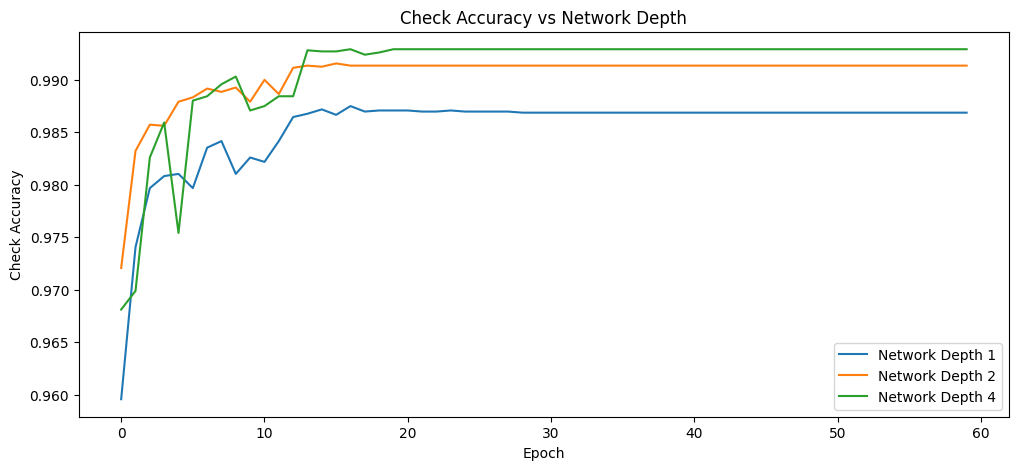

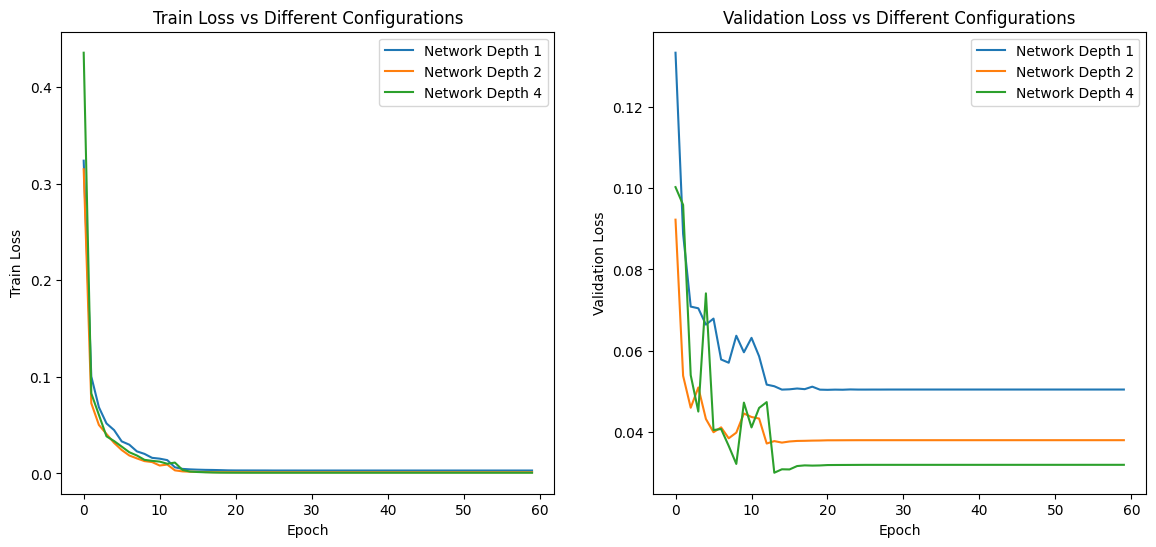

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9852
Accuracy for class 0: 0.9778
Accuracy for class 1: 0.9904
Accuracy for class 2: 0.9825
Accuracy for class 3: 0.9862
Accuracy for class 4: 0.9928
Accuracy for class 5: 0.9877
Accuracy for class 6: 0.9813
Accuracy for class 7: 0.9825
Accuracy for class 8: 0.9815
Accuracy for class 9: 0.9890


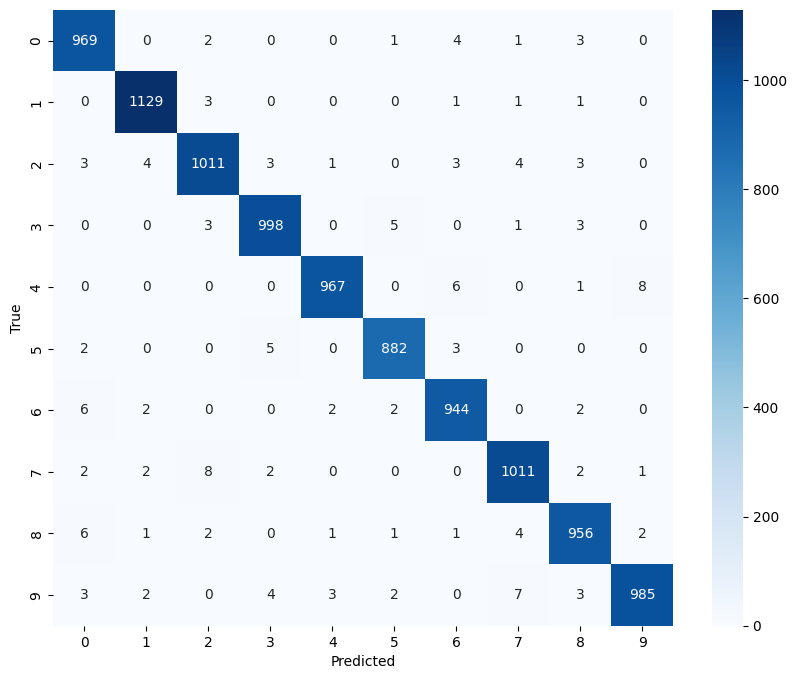

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9913
Accuracy for class 0: 0.9909
Accuracy for class 1: 0.9947
Accuracy for class 2: 0.9884
Accuracy for class 3: 0.9931
Accuracy for class 4: 0.9929
Accuracy for class 5: 0.9855
Accuracy for class 6: 0.9968
Accuracy for class 7: 0.9873
Accuracy for class 8: 0.9917
Accuracy for class 9: 0.9910


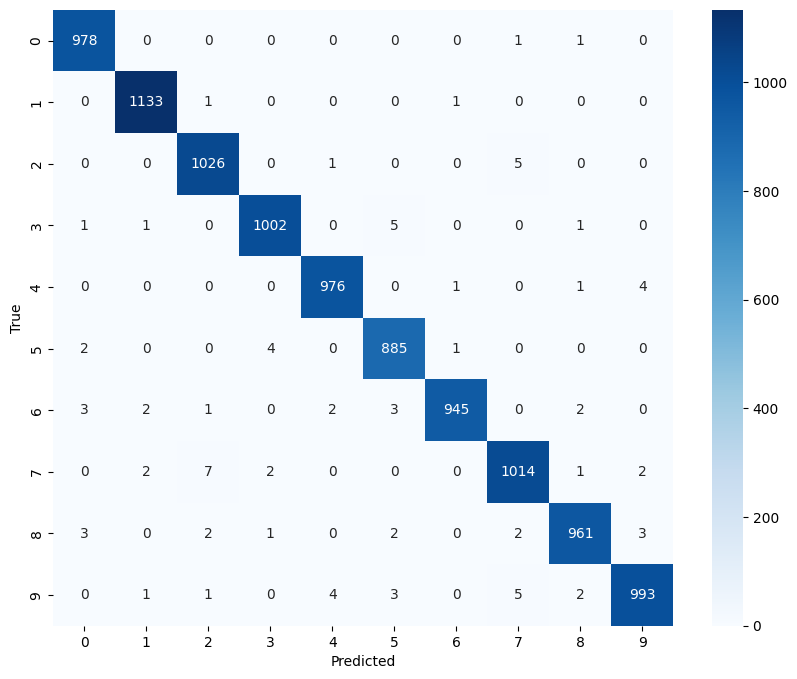

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9932
Accuracy for class 0: 0.9929
Accuracy for class 1: 0.9965
Accuracy for class 2: 0.9904
Accuracy for class 3: 0.9912
Accuracy for class 4: 0.9929
Accuracy for class 5: 0.9944
Accuracy for class 6: 0.9958
Accuracy for class 7: 0.9922
Accuracy for class 8: 0.9938
Accuracy for class 9: 0.9920


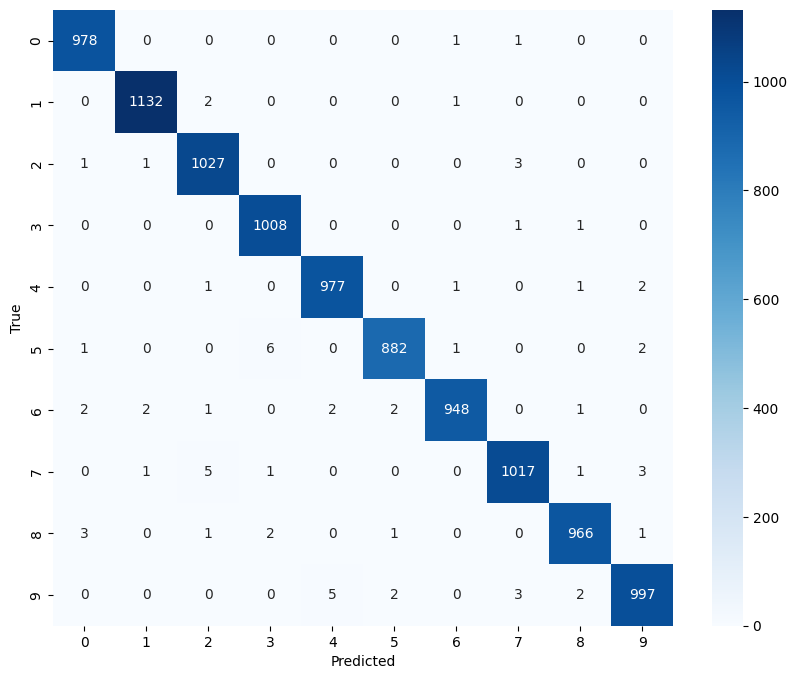

In [8]:
travers = [1, 2, 4]
model_builder = "nd"
model_name = "MNIST_CNN_nd"
plot_name = "Network Depth"



### 卷积核大小影响

Epoch 1/30
Train Loss: 0.3225, Acc: 0.9049 | Check Loss: 0.0965, Acc: 0.9717
Epoch 2/30
Train Loss: 0.0792, Acc: 0.9762 | Check Loss: 0.0662, Acc: 0.9804
Epoch 3/30
Train Loss: 0.0533, Acc: 0.9835 | Check Loss: 0.0534, Acc: 0.9839
Epoch 4/30
Train Loss: 0.0383, Acc: 0.9872 | Check Loss: 0.0495, Acc: 0.9858
Epoch 5/30
Train Loss: 0.0310, Acc: 0.9895 | Check Loss: 0.0442, Acc: 0.9877
Epoch 6/30
Train Loss: 0.0252, Acc: 0.9921 | Check Loss: 0.0416, Acc: 0.9879
Epoch 7/30
Train Loss: 0.0198, Acc: 0.9936 | Check Loss: 0.0430, Acc: 0.9880
Epoch 8/30
Train Loss: 0.0158, Acc: 0.9947 | Check Loss: 0.0373, Acc: 0.9894
Epoch 9/30
Train Loss: 0.0120, Acc: 0.9962 | Check Loss: 0.0401, Acc: 0.9903
Epoch 10/30
Train Loss: 0.0111, Acc: 0.9963 | Check Loss: 0.0504, Acc: 0.9866
Epoch 11/30
Train Loss: 0.0102, Acc: 0.9967 | Check Loss: 0.0511, Acc: 0.9870
Epoch 12/30
Train Loss: 0.0092, Acc: 0.9971 | Check Loss: 0.0398, Acc: 0.9901
Epoch 13/30
Train Loss: 0.0037, Acc: 0.9991 | Check Loss: 0.0374, Acc: 0.

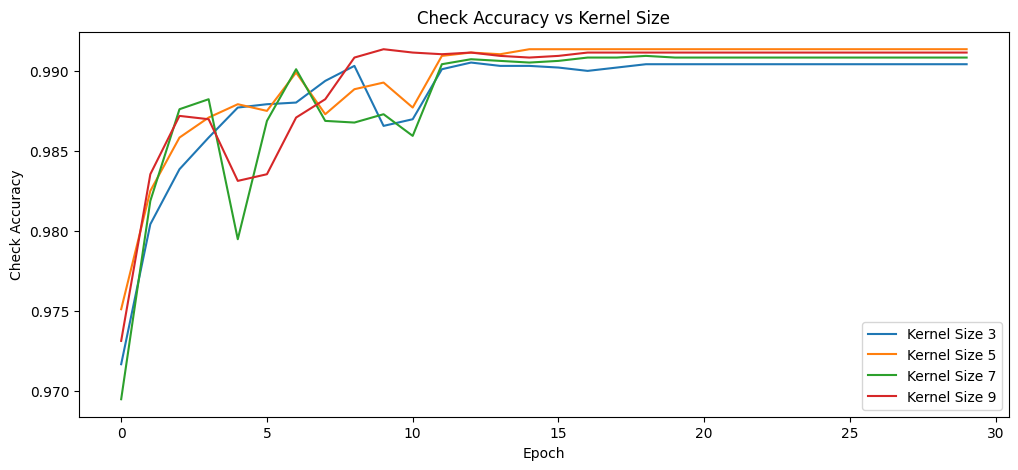

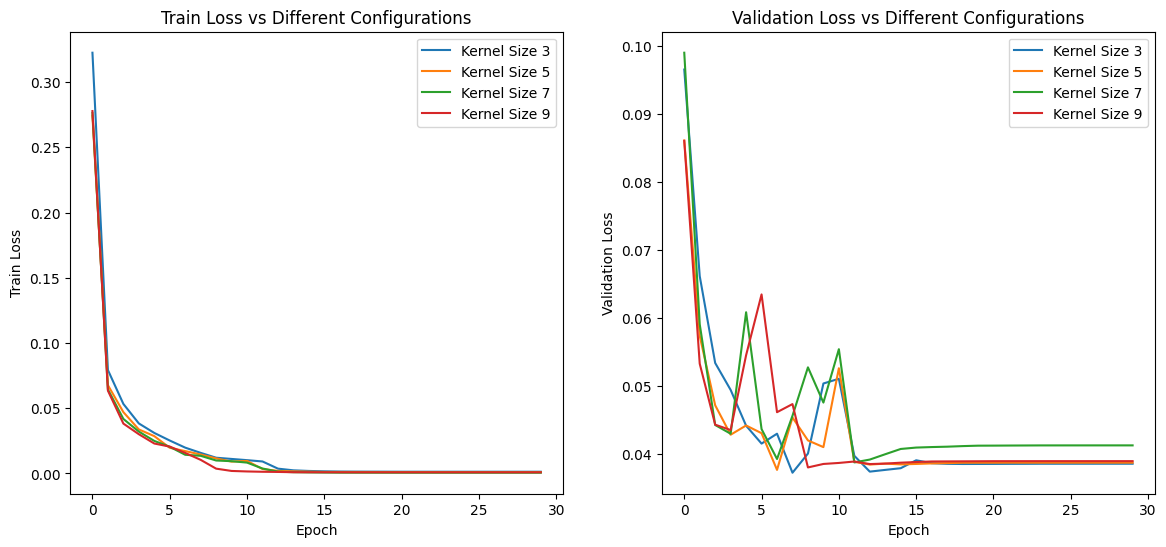

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9914
Accuracy for class 0: 0.9909
Accuracy for class 1: 0.9974
Accuracy for class 2: 0.9837
Accuracy for class 3: 0.9931
Accuracy for class 4: 0.9939
Accuracy for class 5: 0.9844
Accuracy for class 6: 0.9968
Accuracy for class 7: 0.9893
Accuracy for class 8: 0.9898
Accuracy for class 9: 0.9940


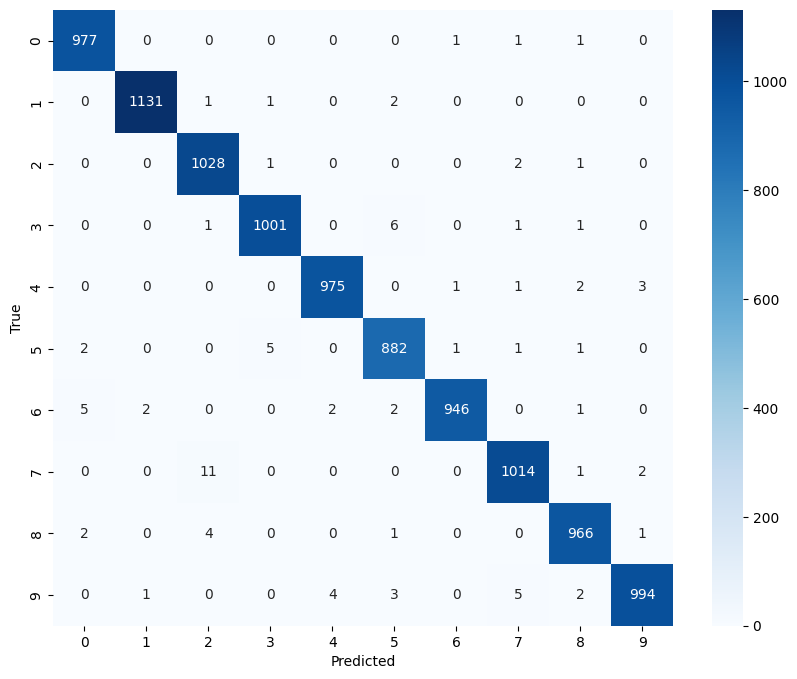

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9913
Accuracy for class 0: 0.9909
Accuracy for class 1: 0.9947
Accuracy for class 2: 0.9894
Accuracy for class 3: 0.9940
Accuracy for class 4: 0.9919
Accuracy for class 5: 0.9833
Accuracy for class 6: 0.9958
Accuracy for class 7: 0.9893
Accuracy for class 8: 0.9897
Accuracy for class 9: 0.9930


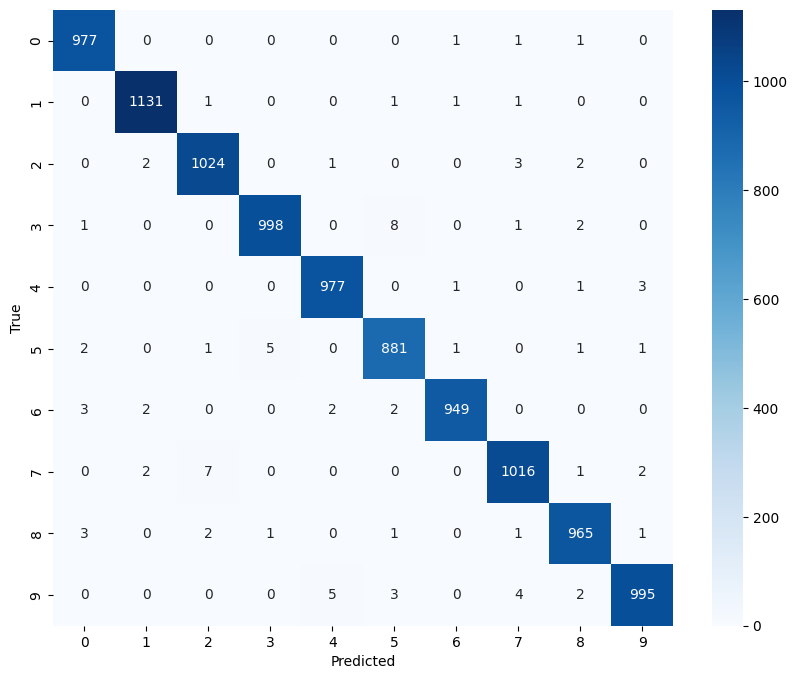

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9919
Accuracy for class 0: 0.9899
Accuracy for class 1: 0.9947
Accuracy for class 2: 0.9894
Accuracy for class 3: 0.9931
Accuracy for class 4: 0.9969
Accuracy for class 5: 0.9866
Accuracy for class 6: 0.9968
Accuracy for class 7: 0.9893
Accuracy for class 8: 0.9898
Accuracy for class 9: 0.9920


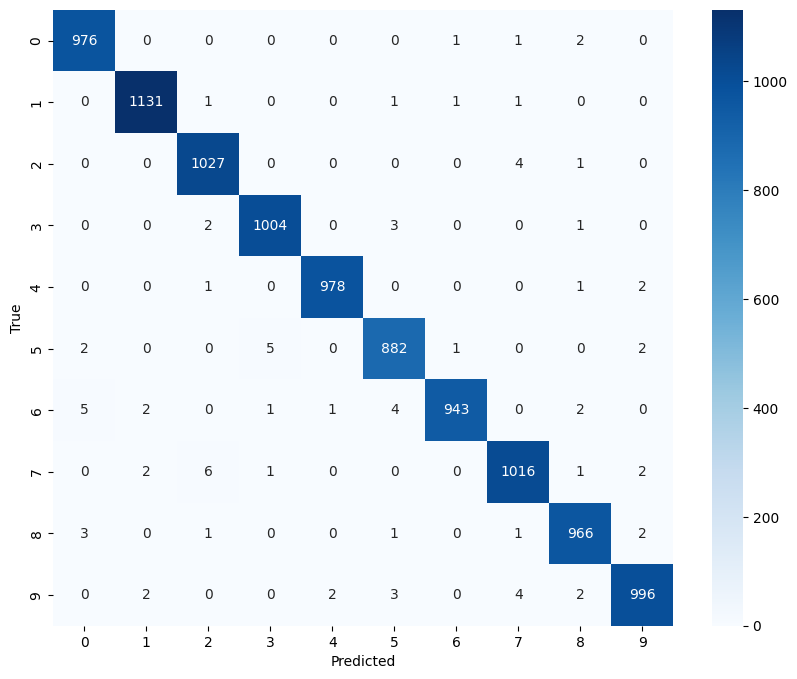

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9913
Accuracy for class 0: 0.9919
Accuracy for class 1: 0.9938
Accuracy for class 2: 0.9932
Accuracy for class 3: 0.9931
Accuracy for class 4: 0.9919
Accuracy for class 5: 0.9855
Accuracy for class 6: 0.9958
Accuracy for class 7: 0.9893
Accuracy for class 8: 0.9878
Accuracy for class 9: 0.9901


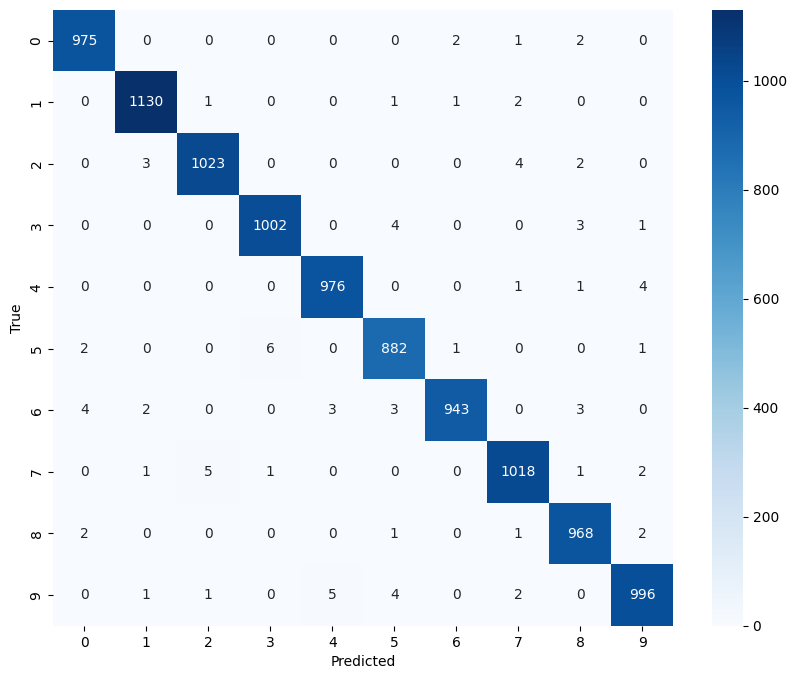

In [9]:
travers = [3, 5, 7, 9]
model_builder = "ks"
model_name = "MNIST_CNN_ks"
plot_name = "Kernel Size"

### Dropout影响

Epoch 1/30
Train Loss: 0.3072, Acc: 0.9085 | Check Loss: 0.1015, Acc: 0.9676
Epoch 2/30
Train Loss: 0.0749, Acc: 0.9777 | Check Loss: 0.0645, Acc: 0.9810
Epoch 3/30
Train Loss: 0.0501, Acc: 0.9850 | Check Loss: 0.0459, Acc: 0.9858
Epoch 4/30
Train Loss: 0.0371, Acc: 0.9885 | Check Loss: 0.0395, Acc: 0.9885
Epoch 5/30
Train Loss: 0.0292, Acc: 0.9904 | Check Loss: 0.0520, Acc: 0.9839
Epoch 6/30
Train Loss: 0.0229, Acc: 0.9930 | Check Loss: 0.0399, Acc: 0.9878
Epoch 7/30
Train Loss: 0.0190, Acc: 0.9943 | Check Loss: 0.0404, Acc: 0.9876
Epoch 8/30
Train Loss: 0.0137, Acc: 0.9957 | Check Loss: 0.0443, Acc: 0.9874
Epoch 9/30
Train Loss: 0.0068, Acc: 0.9983 | Check Loss: 0.0344, Acc: 0.9903
Epoch 10/30
Train Loss: 0.0051, Acc: 0.9989 | Check Loss: 0.0339, Acc: 0.9904
Epoch 11/30
Train Loss: 0.0044, Acc: 0.9993 | Check Loss: 0.0345, Acc: 0.9898
Epoch 12/30
Train Loss: 0.0040, Acc: 0.9994 | Check Loss: 0.0344, Acc: 0.9901
Epoch 13/30
Train Loss: 0.0037, Acc: 0.9993 | Check Loss: 0.0349, Acc: 0.

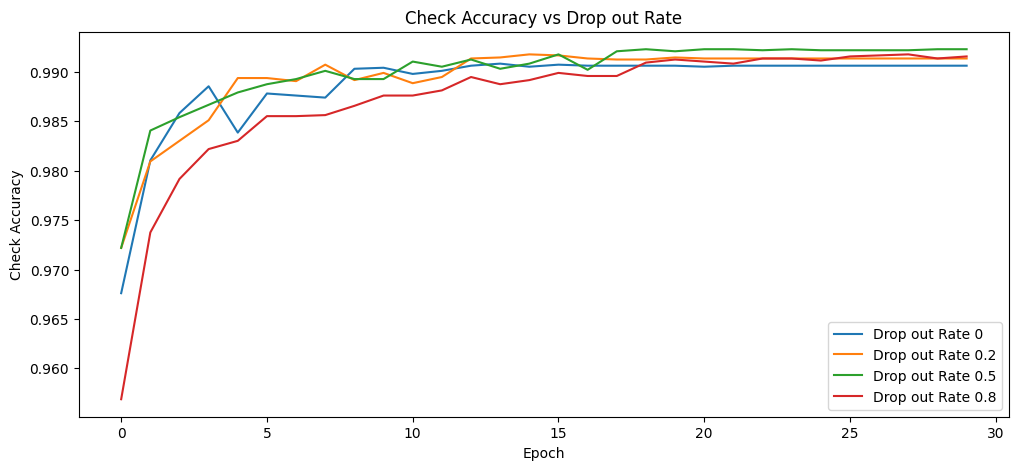

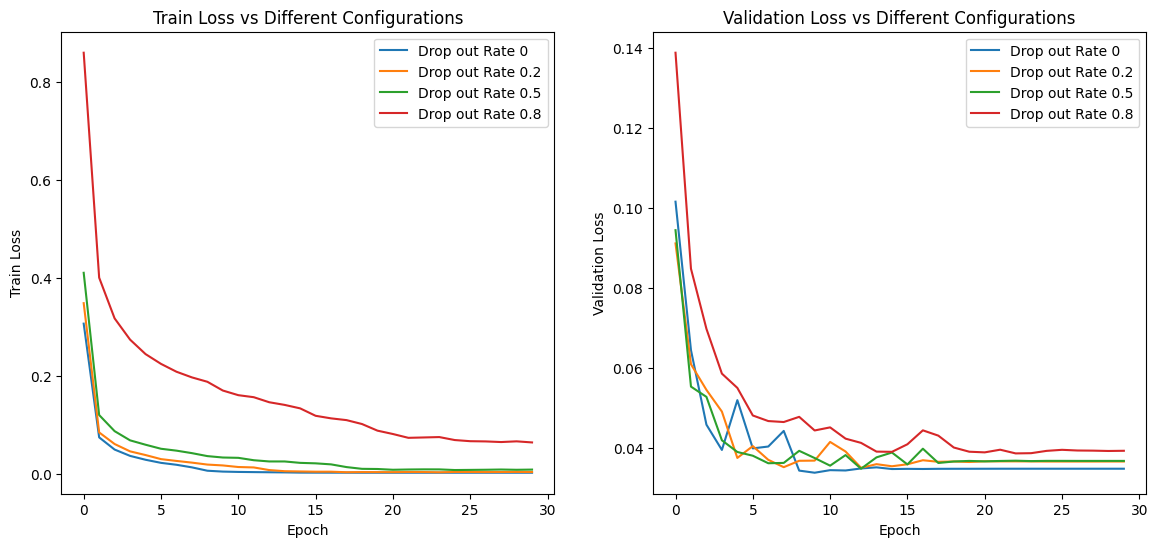

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9901
Accuracy for class 0: 0.9899
Accuracy for class 1: 0.9956
Accuracy for class 2: 0.9865
Accuracy for class 3: 0.9891
Accuracy for class 4: 0.9929
Accuracy for class 5: 0.9833
Accuracy for class 6: 0.9979
Accuracy for class 7: 0.9864
Accuracy for class 8: 0.9867
Accuracy for class 9: 0.9920


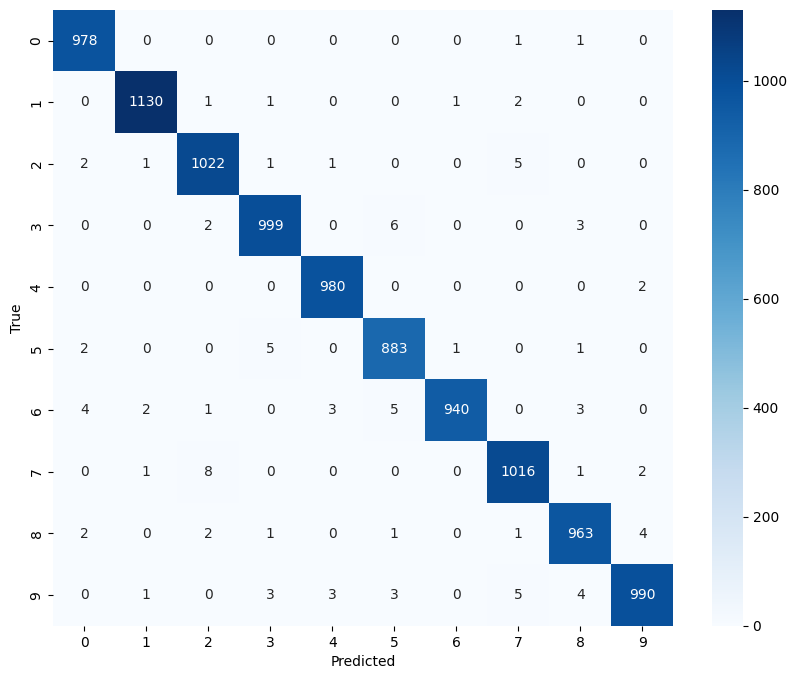

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9917
Accuracy for class 0: 0.9879
Accuracy for class 1: 0.9947
Accuracy for class 2: 0.9884
Accuracy for class 3: 0.9931
Accuracy for class 4: 0.9969
Accuracy for class 5: 0.9910
Accuracy for class 6: 0.9979
Accuracy for class 7: 0.9864
Accuracy for class 8: 0.9918
Accuracy for class 9: 0.9891


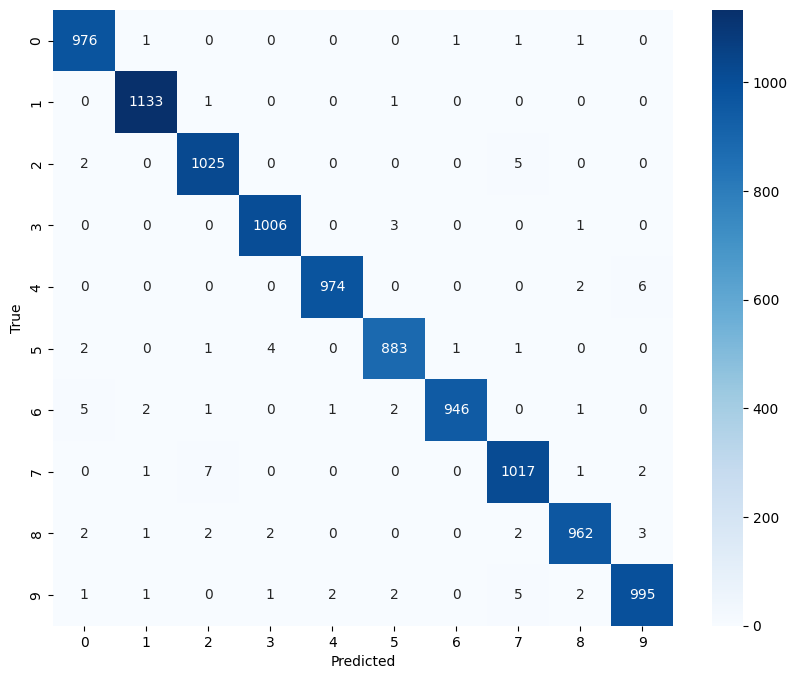

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9929
Accuracy for class 0: 0.9909
Accuracy for class 1: 0.9947
Accuracy for class 2: 0.9922
Accuracy for class 3: 0.9921
Accuracy for class 4: 0.9929
Accuracy for class 5: 0.9910
Accuracy for class 6: 0.9969
Accuracy for class 7: 0.9903
Accuracy for class 8: 0.9938
Accuracy for class 9: 0.9940


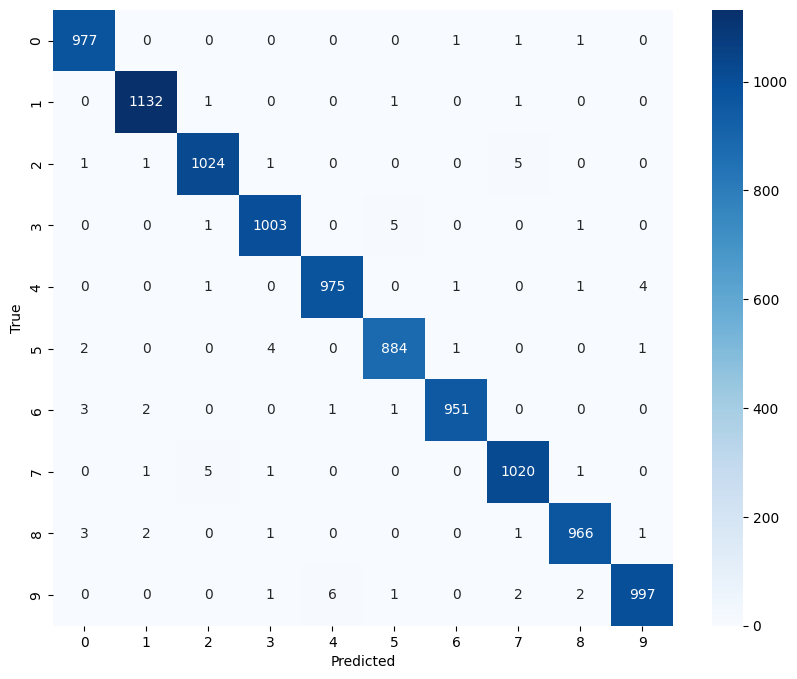

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9920
Accuracy for class 0: 0.9919
Accuracy for class 1: 0.9939
Accuracy for class 2: 0.9865
Accuracy for class 3: 0.9950
Accuracy for class 4: 0.9929
Accuracy for class 5: 0.9910
Accuracy for class 6: 0.9968
Accuracy for class 7: 0.9903
Accuracy for class 8: 0.9908
Accuracy for class 9: 0.9910


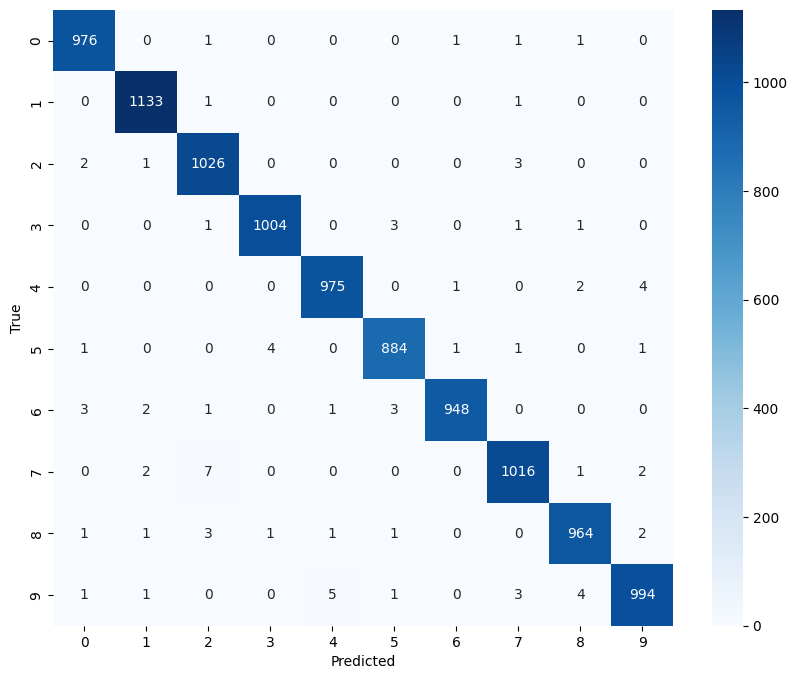

In [10]:
travers = [0,0.2, 0.5, 0.8]
model_builder = "dr"
model_name = "MNIST_CNN_dr"
plot_name = "Drop out Rate"

### BatchNorm影响

Epoch 1/30
Train Loss: 0.2183, Acc: 0.9351 | Check Loss: 0.0868, Acc: 0.9753
Epoch 2/30
Train Loss: 0.0572, Acc: 0.9826 | Check Loss: 0.0585, Acc: 0.9827
Epoch 3/30
Train Loss: 0.0388, Acc: 0.9881 | Check Loss: 0.0480, Acc: 0.9858
Epoch 4/30
Train Loss: 0.0299, Acc: 0.9904 | Check Loss: 0.0485, Acc: 0.9865
Epoch 5/30
Train Loss: 0.0278, Acc: 0.9910 | Check Loss: 0.0416, Acc: 0.9873
Epoch 6/30
Train Loss: 0.0184, Acc: 0.9940 | Check Loss: 0.0441, Acc: 0.9874
Epoch 7/30
Train Loss: 0.0138, Acc: 0.9955 | Check Loss: 0.0443, Acc: 0.9879
Epoch 8/30
Train Loss: 0.0089, Acc: 0.9975 | Check Loss: 0.0444, Acc: 0.9876
Epoch 9/30
Train Loss: 0.0080, Acc: 0.9978 | Check Loss: 0.0402, Acc: 0.9896
Epoch 10/30
Train Loss: 0.0074, Acc: 0.9979 | Check Loss: 0.0451, Acc: 0.9877
Epoch 11/30
Train Loss: 0.0076, Acc: 0.9975 | Check Loss: 0.0464, Acc: 0.9879
Epoch 12/30
Train Loss: 0.0092, Acc: 0.9968 | Check Loss: 0.0434, Acc: 0.9888
Epoch 13/30
Train Loss: 0.0065, Acc: 0.9977 | Check Loss: 0.0478, Acc: 0.

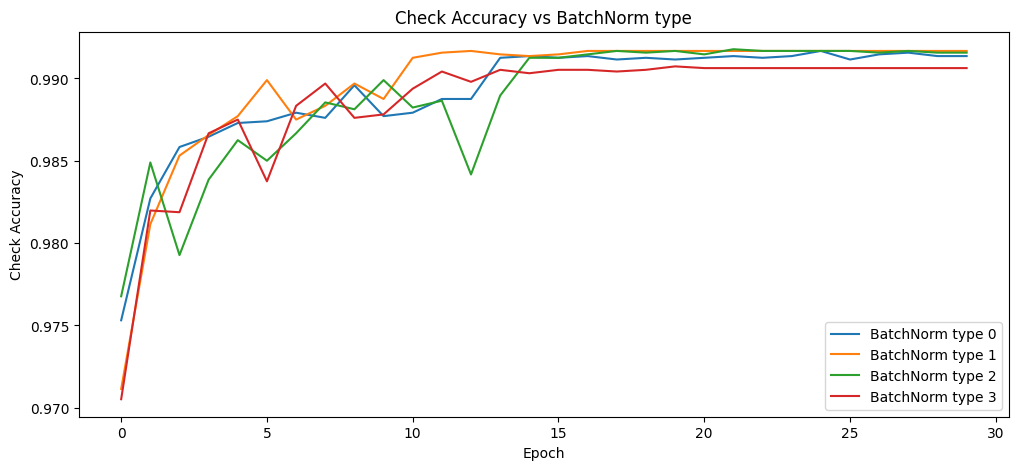

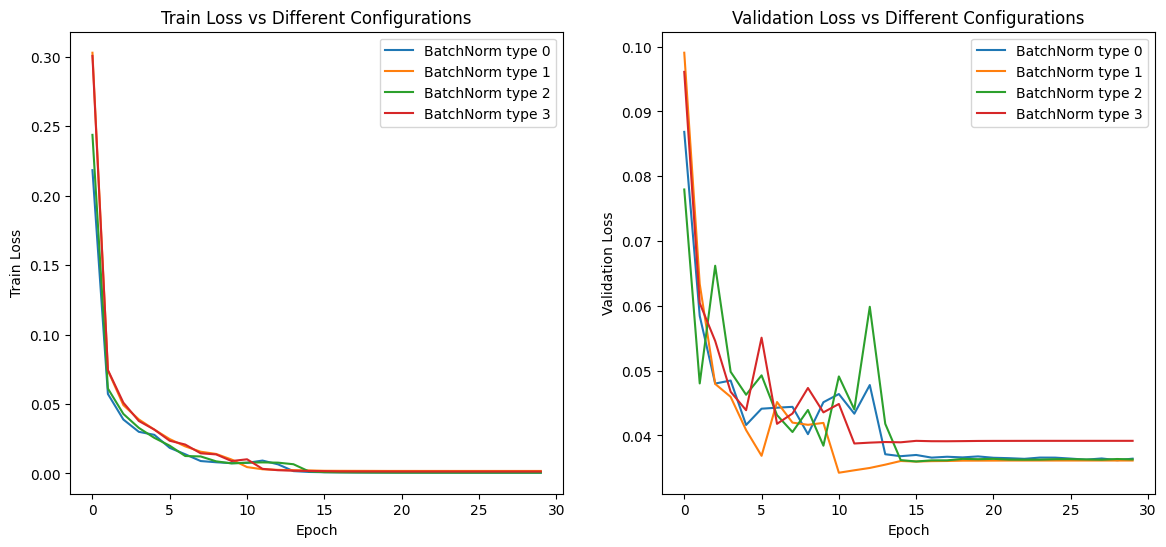

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9907
Accuracy for class 0: 0.9859
Accuracy for class 1: 0.9947
Accuracy for class 2: 0.9884
Accuracy for class 3: 0.9921
Accuracy for class 4: 0.9929
Accuracy for class 5: 0.9866
Accuracy for class 6: 0.9958
Accuracy for class 7: 0.9835
Accuracy for class 8: 0.9918
Accuracy for class 9: 0.9950


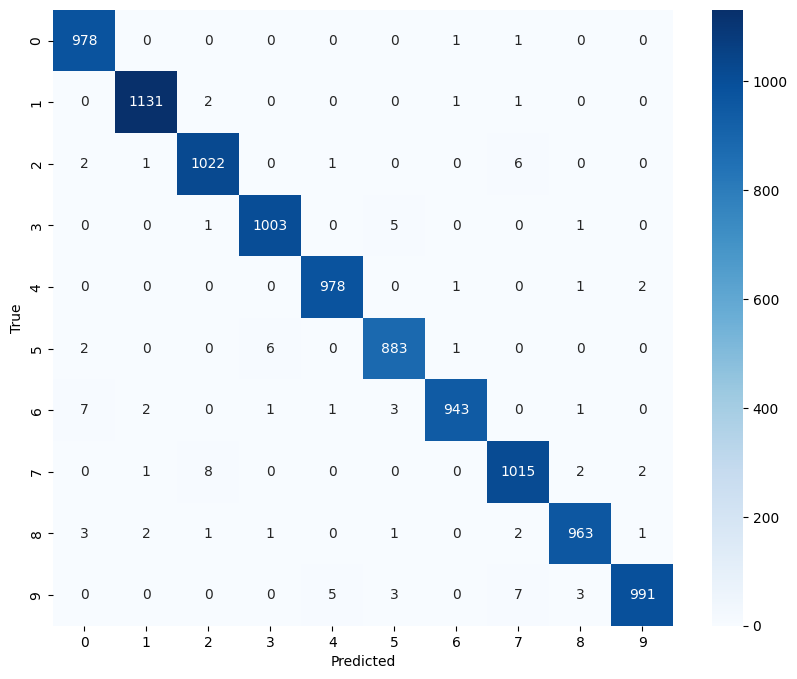

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9909
Accuracy for class 0: 0.9889
Accuracy for class 1: 0.9939
Accuracy for class 2: 0.9903
Accuracy for class 3: 0.9911
Accuracy for class 4: 0.9929
Accuracy for class 5: 0.9854
Accuracy for class 6: 0.9958
Accuracy for class 7: 0.9902
Accuracy for class 8: 0.9897
Accuracy for class 9: 0.9900


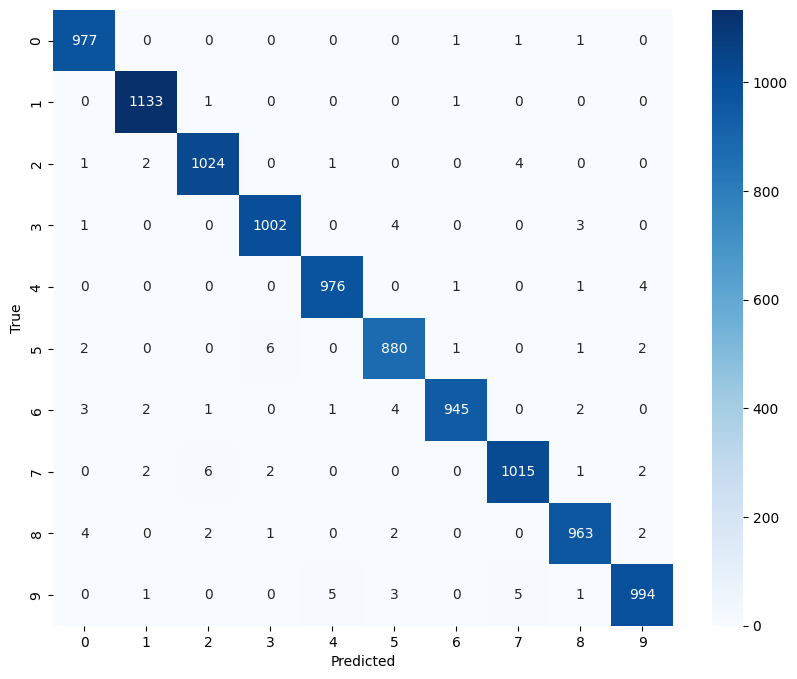

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9922
Accuracy for class 0: 0.9889
Accuracy for class 1: 0.9965
Accuracy for class 2: 0.9865
Accuracy for class 3: 0.9911
Accuracy for class 4: 0.9939
Accuracy for class 5: 0.9888
Accuracy for class 6: 0.9989
Accuracy for class 7: 0.9883
Accuracy for class 8: 0.9928
Accuracy for class 9: 0.9960


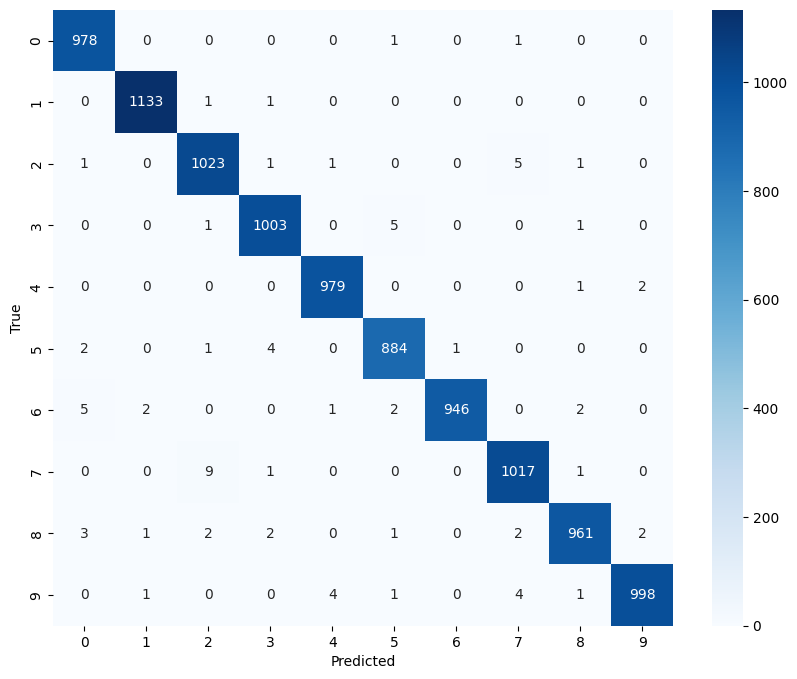

<ipython-input-6-1cec81fe5255>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 0.9910
Accuracy for class 0: 0.9889
Accuracy for class 1: 0.9947
Accuracy for class 2: 0.9874
Accuracy for class 3: 0.9931
Accuracy for class 4: 0.9939
Accuracy for class 5: 0.9877
Accuracy for class 6: 0.9968
Accuracy for class 7: 0.9912
Accuracy for class 8: 0.9857
Accuracy for class 9: 0.9901


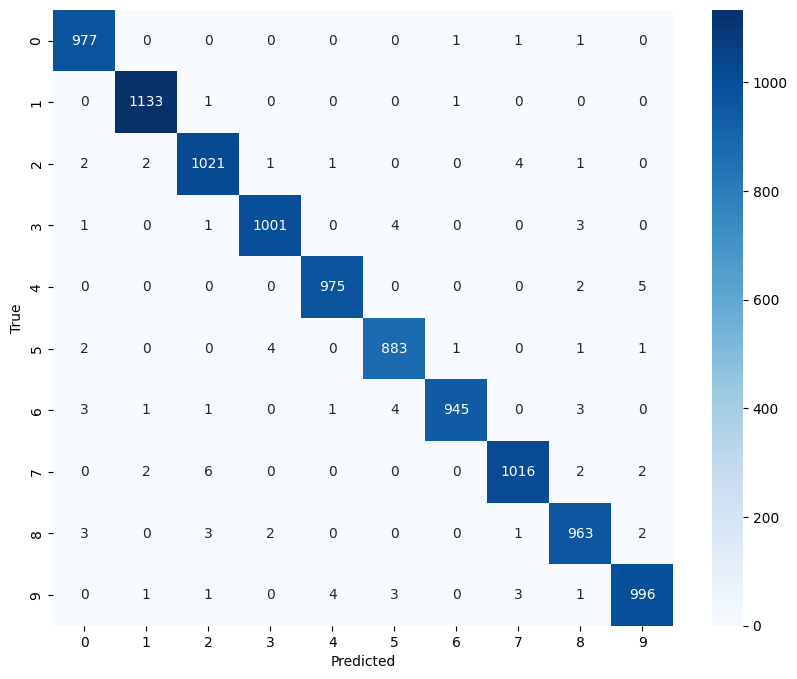

In [11]:
travers = [0, 1, 2, 3]
model_builder = "bn"
model_name = "MNIST_CNN_bn"
plot_name = "BatchNorm type"


### 请首先运行并仅运行上方的一个单元格后再运行此部分（或将此处复制上去）

In [ ]:
results = {}

for traver in travers:
   if model_builder == "nd":
       model = CNN(img_size=imgSize, conv_cnt=traver)
   elif model_builder == "ks":
       model = CNN(img_size=imgSize, convolutionKernel_size=traver)
   elif model_builder == "dr":
       model = CNN(img_size=imgSize, use_dropout=True, dropOut_rate=traver)
   elif model_builder == "bn":
       model = CNN(img_size=imgSize, use_batchnorm=True)
       model_builder = "bn_1"
   elif model_builder == "bn_1":
       model = CNN(img_size=imgSize)
       model_builder = "bn"
   else:
       raise ValueError("model_builder must be one of 'nd', 'ks', 'dr', 'bn'")
   train_loss, check_loss, train_acc, check_acc = ModelTrainer(
       model, train_loader, check_loader, epochs=30
   ).train()
   results[traver] = {
       "train_loss": train_loss,
       "check_loss": check_loss,
       "train_acc": train_acc,
       "check_acc": check_acc,
   }
   shutil.move("MNIST_CNN.pth", f"{model_name}{traver}.pth")


# 绘制结果曲线
plt.figure(figsize=(12, 5))
for traver in travers:
    plt.plot(results[traver]["check_acc"], label=f"{plot_name} {traver}")
plt.xlabel("Epoch")
plt.ylabel("Check Accuracy")
plt.title(f"Check Accuracy vs {plot_name}")
plt.legend()
plt.show()

# 绘制训练和验证损失曲线
plt.figure(figsize=(14, 6))

# 绘制所有情况的训练损失曲线
plt.subplot(1, 2, 1)
for traver in travers:
    plt.plot(results[traver]["train_loss"], label=f"{plot_name} {traver}")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss vs Different Configurations")
plt.legend()

# 绘制所有情况的验证损失曲线
plt.subplot(1, 2, 2)
for traver in travers:
    plt.plot(results[traver]["check_loss"], label=f"{plot_name} {traver}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Different Configurations")
plt.legend()

plt.show()

for traver in travers:
    if model_builder == "nd":
        model = CNN(img_size=imgSize, conv_cnt=traver)
    elif model_builder == "ks":
        model = CNN(img_size=imgSize, convolutionKernel_size=traver)
    elif model_builder == "dr":
        model = CNN(img_size=imgSize, use_dropout=True, dropOut_rate=traver)
    elif model_builder == "bn":
        model = CNN(img_size=imgSize, use_batchnorm=True)
        model_builder = "bn_1"
    elif model_builder == "bn_1":
        model = CNN(img_size=imgSize)
        model_builder = "bn"
    else:
        raise ValueError("model_builder must be one of 'nd', 'ks', 'dr', 'bn'")
    evaluate_model(
        model,
        test_loader,
        f"{model_name}{traver}.pth",
    )